In [1]:
import sklearn
import numpy as np
import torch
import matplotlib.pyplot as plt

# Make toy datasets

In [2]:
from sklearn.datasets import make_circles

In [3]:
n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [4]:
len(X), len(y)

(1000, 1000)

In [5]:
X[:5]

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       [-0.39373073,  0.69288277],
       [ 0.44220765, -0.89672343]])

In [6]:
y[:5]

array([1, 1, 1, 1, 0])

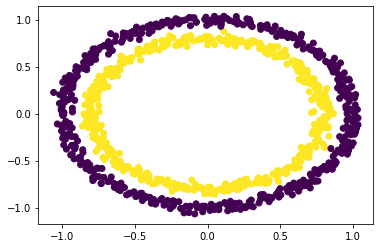

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y)

# Turn data into tensors and train&test datasets

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
torch.__version__

'1.13.1+cu116'

In [10]:
type(X)

numpy.ndarray

In [11]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]), tensor([1., 1., 1., 1., 0.]))

In [12]:
type(X), type(y)

(torch.Tensor, torch.Tensor)

In [13]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

# Build classification model

In [16]:
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
device

'cpu'

In [18]:
# 1. Constract a model that subclass nn.Module
class CircleModelv0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5, bias=True, device=device)
    self.layer_2 = nn.Linear(in_features=5, out_features=1, bias=True, device=device)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))

In [19]:
model_0 = CircleModelv0().to(device)
model_0

CircleModelv0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
model_1 = nn.Sequential(nn.Linear(in_features=2, out_features=5),
                        nn.Linear(in_features=5, out_features=1)).to(device)

In [21]:
model_1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [22]:
model_1.state_dict()

OrderedDict([('0.weight', tensor([[-0.5857, -0.3193],
                      [ 0.2015,  0.0855],
                      [-0.4786, -0.3483],
                      [ 0.1313,  0.3908],
                      [ 0.3639, -0.3923]])),
             ('0.bias', tensor([ 0.2150,  0.5552, -0.4659,  0.6792, -0.0120])),
             ('1.weight',
              tensor([[ 0.2908,  0.0763,  0.2697, -0.0127,  0.2911]])),
             ('1.bias', tensor([0.0602]))])

In [23]:
# Make predictions without training
with torch.inference_mode():
  untrained_pred = model_1(X_test)
untrained_pred

tensor([[-0.1097],
        [-0.2629],
        [ 0.2479],
        [-0.2108],
        [ 0.1777],
        [ 0.0847],
        [-0.2913],
        [-0.2100],
        [ 0.2503],
        [-0.2740],
        [-0.1240],
        [-0.1506],
        [-0.2570],
        [ 0.3043],
        [ 0.2649],
        [-0.0890],
        [-0.2463],
        [-0.0637],
        [-0.0295],
        [ 0.0374],
        [-0.2705],
        [-0.0883],
        [ 0.0190],
        [-0.0058],
        [-0.3105],
        [-0.2424],
        [ 0.3581],
        [ 0.0289],
        [ 0.2778],
        [ 0.2905],
        [-0.2276],
        [-0.3196],
        [-0.1557],
        [ 0.2556],
        [-0.1379],
        [-0.2295],
        [-0.1733],
        [ 0.2932],
        [ 0.2883],
        [ 0.3028],
        [ 0.0362],
        [ 0.2109],
        [-0.2385],
        [ 0.2181],
        [-0.1726],
        [-0.2431],
        [ 0.1559],
        [-0.2779],
        [-0.2015],
        [ 0.1224],
        [-0.1985],
        [-0.1852],
        [-0.

In [24]:
len(untrained_pred), untrained_pred.shape

(200, torch.Size([200, 1]))

In [25]:
len(X_test), X_test.shape

(200, torch.Size([200, 2]))

In [26]:
y_test[:5], untrained_pred[:5]

(tensor([1., 0., 1., 0., 1.]), tensor([[-0.1097],
         [-0.2629],
         [ 0.2479],
         [-0.2108],
         [ 0.1777]]))

In [27]:
# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.01)

In [28]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_true)) * 100
  return acc

In [29]:
model_1.eval()
with torch.inference_mode():
  y_logits = model_1(X_test.to(device))

In [30]:
y_logits[:5]

tensor([[-0.1097],
        [-0.2629],
        [ 0.2479],
        [-0.2108],
        [ 0.1777]])

In [31]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [32]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4726],
        [0.4346],
        [0.5617],
        [0.4475],
        [0.5443],
        [0.5212],
        [0.4277],
        [0.4477],
        [0.5623],
        [0.4319],
        [0.4690],
        [0.4624],
        [0.4361],
        [0.5755],
        [0.5658],
        [0.4778],
        [0.4387],
        [0.4841],
        [0.4926],
        [0.5093],
        [0.4328],
        [0.4779],
        [0.5048],
        [0.4986],
        [0.4230],
        [0.4397],
        [0.5886],
        [0.5072],
        [0.5690],
        [0.5721],
        [0.4434],
        [0.4208],
        [0.4612],
        [0.5636],
        [0.4656],
        [0.4429],
        [0.4568],
        [0.5728],
        [0.5716],
        [0.5751],
        [0.5090],
        [0.5525],
        [0.4406],
        [0.5543],
        [0.4570],
        [0.4395],
        [0.5389],
        [0.4310],
        [0.4498],
        [0.5306],
        [0.4505],
        [0.4538],
        [0.4956],
        [0.5640],
        [0.4529],
        [0

In [33]:
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
      

In [34]:
y_preds = torch.round(torch.sigmoid(model_1(X_test.to(device))))
print(torch.eq(y_preds.squeeze(), y_test))

tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True, False, False, False,  True, False, False,
         True,  True,  True,  True,  True,  True, False, False, False,  True,
        False,  True,  True,  True,  True, False, False,  True,  True,  True,
         True,  True, False, False,  True, False, False,  True, False,  True,
         True,  True,  True, False, False, False, False,  True,  True, False,
         True,  True, False,  True, False, False, False,  True,  True,  True,
         True,  True, False,  True, False,  True,  True,  True,  True, False,
        False, False,  True,  True,  True, False, False, False, False,  True,
         True,  True,  True,  True,  True,  True, False,  True, False,  True,
         True, False, False, False, False, False,  True,  True, False, False,
        False, False,  True,  True, False, False,  True, False,  True, False,
         True, False,  True,  True, False, False,  True, False, 

# Build and training and test loop

In [35]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [36]:
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()

  # Forward
  y_logits = model_1(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))
  
  # Loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_preds)

  # Optimizer
  optimizer.zero_grad()

  # Backward
  loss.backward()

  # Optimizer step
  optimizer.step()

  ### Test
  model_1.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = model_1(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    # Calculate loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_preds)

  if epoch%10 == 0:
    print(f"Epoch: {epoch:>3d} | Loss: {loss:>8f} | Accuracy: {acc:.2f}% | Test loss: {test_loss:>8f} | Test accuracy: {test_acc:.2f}%")

Epoch:   0 | Loss: 0.701417 | Accuracy: 49.50% | Test loss: 0.691149 | Test accuracy: 54.50%
Epoch:  10 | Loss: 0.693940 | Accuracy: 49.38% | Test loss: 0.692093 | Test accuracy: 53.00%
Epoch:  20 | Loss: 0.693093 | Accuracy: 50.62% | Test loss: 0.696099 | Test accuracy: 46.50%
Epoch:  30 | Loss: 0.693105 | Accuracy: 50.88% | Test loss: 0.695920 | Test accuracy: 47.00%
Epoch:  40 | Loss: 0.693005 | Accuracy: 50.75% | Test loss: 0.694758 | Test accuracy: 47.50%
Epoch:  50 | Loss: 0.692986 | Accuracy: 51.38% | Test loss: 0.694485 | Test accuracy: 45.50%
Epoch:  60 | Loss: 0.692987 | Accuracy: 51.25% | Test loss: 0.694480 | Test accuracy: 47.00%
Epoch:  70 | Loss: 0.692981 | Accuracy: 51.38% | Test loss: 0.694619 | Test accuracy: 46.00%
Epoch:  80 | Loss: 0.692981 | Accuracy: 51.50% | Test loss: 0.694779 | Test accuracy: 44.50%
Epoch:  90 | Loss: 0.692980 | Accuracy: 51.12% | Test loss: 0.694722 | Test accuracy: 46.00%
Epoch: 100 | Loss: 0.692980 | Accuracy: 51.25% | Test loss: 0.694645 |

# Evaluate model and visualize

In [37]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
  print("helper_functions.py already exists, skipping download.")
else:
  print("Doanloading helper_functions.py ......")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

Doanloading helper_functions.py ......


In [38]:
from helper_functions import plot_decision_boundary, plot_predictions

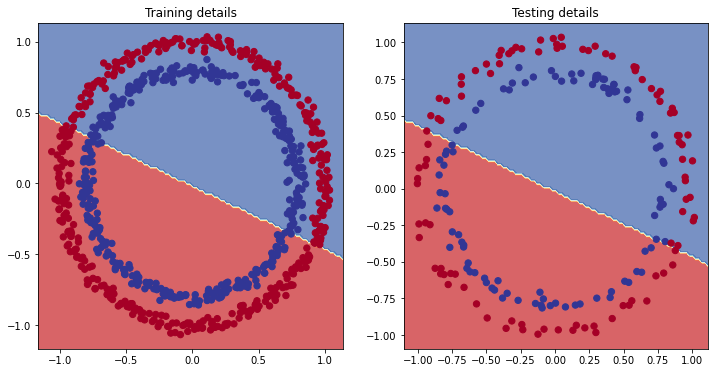

In [39]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Training details')
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title('Testing details')
plot_decision_boundary(model_1, X_test, y_test)

In [40]:
class CircleModelv1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=50)
    self.layer_2 = nn.Linear(in_features=50, out_features=100)
    self.layer_3 = nn.Linear(in_features=100, out_features=80)
    self.layer_4 = nn.Linear(in_features=80, out_features=40)
    self.layer_5 = nn.Linear(in_features=40, out_features=1)

  def forward(self, x):
    z = self.layer_1(x)
    z = self.layer_2(z)
    z = self.layer_3(z)
    z = self.layer_4(z)
    z = self.layer_5(z)
    return z

In [41]:
model_11 = CircleModelv1()
model_11

CircleModelv1(
  (layer_1): Linear(in_features=2, out_features=50, bias=True)
  (layer_2): Linear(in_features=50, out_features=100, bias=True)
  (layer_3): Linear(in_features=100, out_features=80, bias=True)
  (layer_4): Linear(in_features=80, out_features=40, bias=True)
  (layer_5): Linear(in_features=40, out_features=1, bias=True)
)

In [42]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_11.parameters(), lr=0.01)

In [43]:
from torch.optim.optimizer import Optimizer
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
  ### Training
  model_11.train()
  
  # Put data to the target device
  X_train, y_train = X_train.to(device), y_train.to(device)
  X_test, y_test = X_test.to(device), y_test.to(device)

  # Forward pass
  y_logits = model_11(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  # Loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_preds)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Backward pass
  loss.backward()

  # Optimizer step
  optimizer.step()

  ### Testing
  model_11.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = model_11(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    # Calculate loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_preds)
    # Print results
    if epoch%100 == 0:
      print(f"Epoch: {epoch:>3d} | Loss: {loss:>10f} | Accuracy: {acc:.2f}% | Test loss: {test_loss:>10f} | Test accuracy: {test_acc:.2f}%")

Epoch:   0 | Loss:   0.693703 | Accuracy: 43.88% | Test loss:   0.834894 | Test accuracy: 50.00%
Epoch: 100 | Loss:   0.692980 | Accuracy: 51.00% | Test loss:   0.694666 | Test accuracy: 45.50%
Epoch: 200 | Loss:   0.692980 | Accuracy: 51.00% | Test loss:   0.694680 | Test accuracy: 46.00%
Epoch: 300 | Loss:   0.692980 | Accuracy: 51.00% | Test loss:   0.694680 | Test accuracy: 46.00%
Epoch: 400 | Loss:   0.692980 | Accuracy: 51.00% | Test loss:   0.694680 | Test accuracy: 46.00%
Epoch: 500 | Loss:   0.692980 | Accuracy: 51.00% | Test loss:   0.694680 | Test accuracy: 46.00%
Epoch: 600 | Loss:   0.692980 | Accuracy: 51.00% | Test loss:   0.694680 | Test accuracy: 46.00%
Epoch: 700 | Loss:   0.692980 | Accuracy: 51.00% | Test loss:   0.694680 | Test accuracy: 46.00%
Epoch: 800 | Loss:   0.692980 | Accuracy: 51.00% | Test loss:   0.694680 | Test accuracy: 46.00%
Epoch: 900 | Loss:   0.692980 | Accuracy: 51.00% | Test loss:   0.694680 | Test accuracy: 46.00%


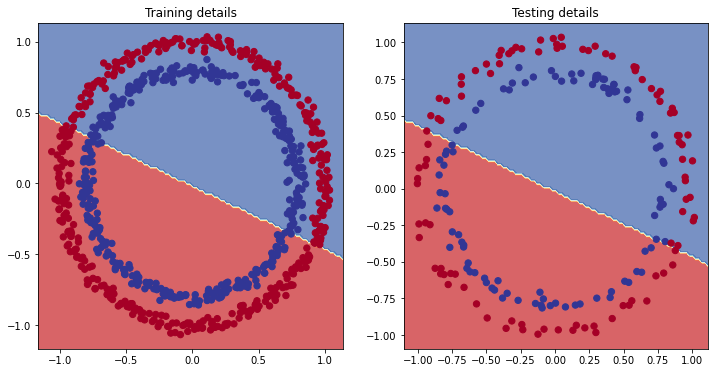

In [44]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Training details')
plot_decision_boundary(model_11, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title('Testing details')
plot_decision_boundary(model_11, X_test, y_test)

# Non-linearity model

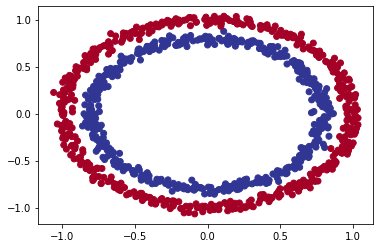

In [46]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu);

In [47]:
# Convert data to tensors and train-test split
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

X[:5]

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]])

In [49]:
# Build a model with non-linear activation function
from torch import nn

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

In [51]:
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [52]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

# Train a model with non-linearity

In [61]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through the data
epochs = 1000

for epoch in range(epochs):
  # Training
  model_3.train()

  # Forward pass
  y_scores = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_scores))

  # Calculate loss
  train_loss = loss_fn(y_scores, y_train)
  train_acc = accuracy_fn(y_train, y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Loss backwards
  train_loss.backward()

  # Step the optimizer
  optimizer.step()

  # Test
  model_3.eval()
  with torch.inference_mode():
    test_scores = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_scores))

    test_loss = loss_fn(test_scores, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  # Print out what happened
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {train_loss}, Acc: {train_acc:.2f}% | Test Loss: {test_loss}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.6729821562767029, Acc: 59.62% | Test Loss: 0.6706721782684326, Test Acc: 59.50%
Epoch: 100 | Loss: 0.6666046977043152, Acc: 61.12% | Test Loss: 0.6654379963874817, Test Acc: 62.00%
Epoch: 200 | Loss: 0.6559023261070251, Acc: 64.25% | Test Loss: 0.6570637226104736, Test Acc: 65.00%
Epoch: 300 | Loss: 0.6390023231506348, Acc: 67.50% | Test Loss: 0.6434189081192017, Test Acc: 69.00%
Epoch: 400 | Loss: 0.6073739528656006, Acc: 74.00% | Test Loss: 0.6181212067604065, Test Acc: 74.50%
Epoch: 500 | Loss: 0.5476500988006592, Acc: 90.00% | Test Loss: 0.5664292573928833, Test Acc: 85.00%
Epoch: 600 | Loss: 0.44890037178993225, Acc: 96.75% | Test Loss: 0.4762657582759857, Test Acc: 94.50%
Epoch: 700 | Loss: 0.3248763680458069, Acc: 99.00% | Test Loss: 0.35719162225723267, Test Acc: 98.50%
Epoch: 800 | Loss: 0.21182265877723694, Acc: 99.88% | Test Loss: 0.246634840965271, Test Acc: 99.00%
Epoch: 900 | Loss: 0.15725840628147125, Acc: 99.75% | Test Loss: 0.1934869885444641, Test A

# Make predictions and evaluate the non-linear model

In [58]:
# Make predictions
model_3.eval()
with torch.inference_mode():
  y_scores = model_3(X_test).squeeze()
  y_preds = torch.round(torch.sigmoid(y_scores))

In [59]:
y_test[:10], y_preds[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([0., 0., 1., 0., 0., 1., 1., 1., 1., 0.]))

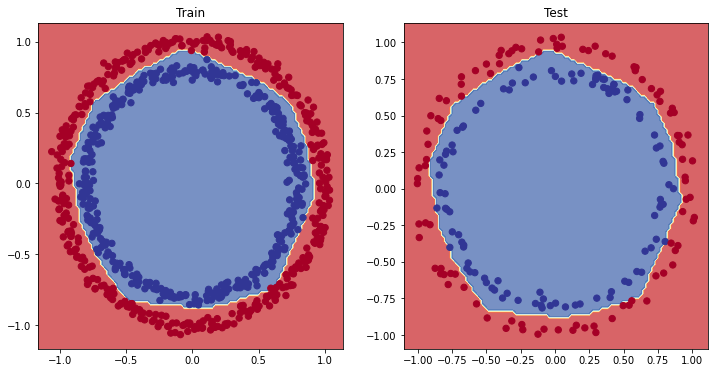

In [62]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_3, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_3, X_test, y_test)

In [63]:
model_3.state_dict()

OrderedDict([('layer1.weight', tensor([[-1.0126, -0.2535],
                      [-0.7465,  1.3921],
                      [-2.2811,  0.5545],
                      [ 0.2485,  0.2298],
                      [ 0.2855,  2.1588],
                      [ 0.1554,  0.0910],
                      [-1.5981,  0.6216],
                      [ 0.8506, -0.7198],
                      [ 0.6074,  0.1576],
                      [-1.6004, -1.6611]])),
             ('layer1.bias',
              tensor([-0.1939, -0.2679, -0.6398, -0.4035, -0.1005, -0.5283,  1.7671,  0.8388,
                      -0.6657, -0.2362])),
             ('layer2.weight',
              tensor([[ 0.1634,  0.0725, -0.1108,  0.1651,  0.1901,  0.1182, -0.0326, -0.0824,
                        0.0338, -0.0559],
                      [ 0.3046,  0.8796,  1.3522, -0.0313,  0.7784,  0.0046,  0.0898, -0.5597,
                        0.0886,  0.2574],
                      [-0.1167,  0.2663,  0.1232, -0.0157, -0.1907, -0.1935, -0.2833, -0.

# Replicate non-linear activation functions with pure PyTorch

In [64]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

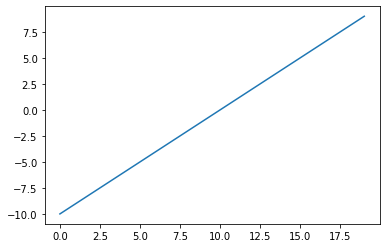

In [65]:
plt.plot(A)

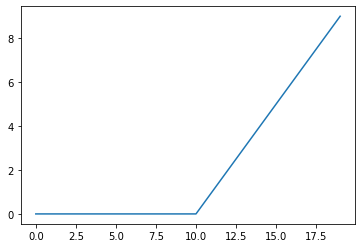

In [66]:
plt.plot(torch.relu(A))

In [69]:
def relu(x):
  return torch.max(torch.tensor(0), x)

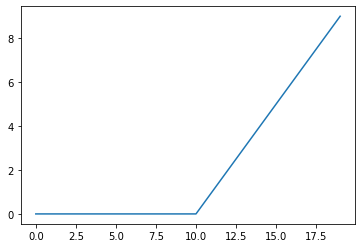

In [70]:
plt.plot(relu(A))

In [71]:
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

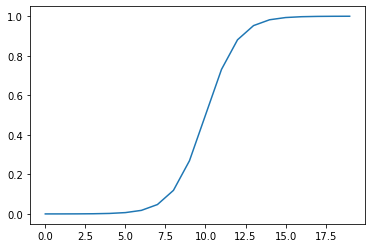

In [72]:
plt.plot(sigmoid(A))

# Multi-class classification problem

In [73]:
from sklearn.datasets import make_blobs

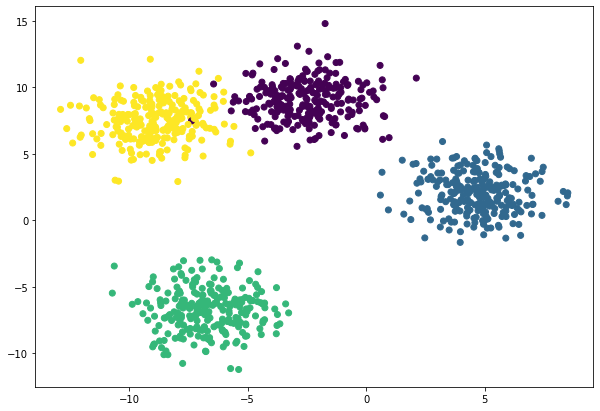

In [116]:
from IPython.lib.security import random
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=42)

# Turn data into tensor
X_blob = torch.from_numpy(X_blob).type(torch.float32)
y_blob = torch.from_numpy(y_blob).type(torch.long)

# Split data into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob)

In [120]:
y_blob[0].dtype

torch.int64

In [111]:
# Create device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [86]:
# Build multi-class model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """
    Initializes nulti-class classification model.

    Args:
      input_features(int): Number of input features to the model
      output_features(int): Number of output features (number of output classes)
      hidden_units(int): Number of hidden units between layers, default 8 
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )
  def forward(self, x):
    return self.linear_layer_stack(x)

In [87]:
# Create an instance of BlobModel
model_4 = BlobModel(2, 4, 8)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [88]:
# Create loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

In [89]:
X_blob_test.dtype

torch.float32

In [103]:
test_pred_probs = model_4(X_blob_test)[:4]
test_pred_probs

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963]], grad_fn=<SliceBackward0>)

In [106]:
torch.nn.functional.softmax(test_pred_probs, dim=1)

tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320]], grad_fn=<SoftmaxBackward0>)

In [107]:
torch.argmax(torch.nn.functional.softmax(test_pred_probs, dim=1), dim=1)

tensor([1, 0, 0, 0])

In [105]:
y_blob_train[:4]

tensor([1., 0., 2., 2.])

In [122]:
# Ramdom seet
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Build a training loop
epochs = 1000

# Put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
  # Train mode
  model_4.train()

  # Forward pass
  pred_probs = model_4(X_blob_train)
  preds = torch.argmax(torch.nn.functional.softmax(pred_probs, dim=1), dim=1)

  # Calculate loss and acc
  train_loss = loss_fn(pred_probs, y_blob_train)
  train_acc = accuracy_fn(y_blob_train, preds)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Backpropagate loss
  train_loss.backward()

  # ptimizer step
  optimizer.step()

  # Testing
  model_4.eval()
  with torch.inference_mode():
    test_pred_probs = model_4(X_blob_test)
    test_preds = torch.argmax(torch.nn.functional.softmax(test_pred_probs, dim=1), dim=1)
    test_loss = loss_fn(test_pred_probs, y_blob_test)
    test_acc = accuracy_fn(y_blob_test, test_preds)

  # Print out results
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {train_loss}, Acc: {train_acc:.2f}% | Test Loss: {test_loss}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.0636167526245117, Acc: 54.62% | Test Loss: 1.0038625001907349, Test Acc: 55.00%
Epoch: 100 | Loss: 0.03294934332370758, Acc: 99.25% | Test Loss: 0.02413254976272583, Test Acc: 99.50%
Epoch: 200 | Loss: 0.026546986773610115, Acc: 99.25% | Test Loss: 0.01648036576807499, Test Acc: 99.50%
Epoch: 300 | Loss: 0.02501974254846573, Acc: 99.25% | Test Loss: 0.014386134222149849, Test Acc: 99.50%
Epoch: 400 | Loss: 0.024268820881843567, Acc: 99.25% | Test Loss: 0.013345764018595219, Test Acc: 99.50%
Epoch: 500 | Loss: 0.023770470172166824, Acc: 99.25% | Test Loss: 0.012677598744630814, Test Acc: 99.50%
Epoch: 600 | Loss: 0.023388775065541267, Acc: 99.25% | Test Loss: 0.012179805897176266, Test Acc: 99.50%
Epoch: 700 | Loss: 0.02306857332587242, Acc: 99.25% | Test Loss: 0.011790263466536999, Test Acc: 99.50%
Epoch: 800 | Loss: 0.022786589339375496, Acc: 99.25% | Test Loss: 0.01146912295371294, Test Acc: 99.50%
Epoch: 900 | Loss: 0.022530624642968178, Acc: 99.25% | Test Loss: 0

In [123]:
model_4.eval()
with torch.inference_mode():
  y_scores = model_4(X_blob_test)
  y_pred_probs = torch.nn.functional.softmax(y_scores, dim=1)
  y_preds = torch.argmax(y_pred_probs, dim=1)

In [124]:
y_preds

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 0, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

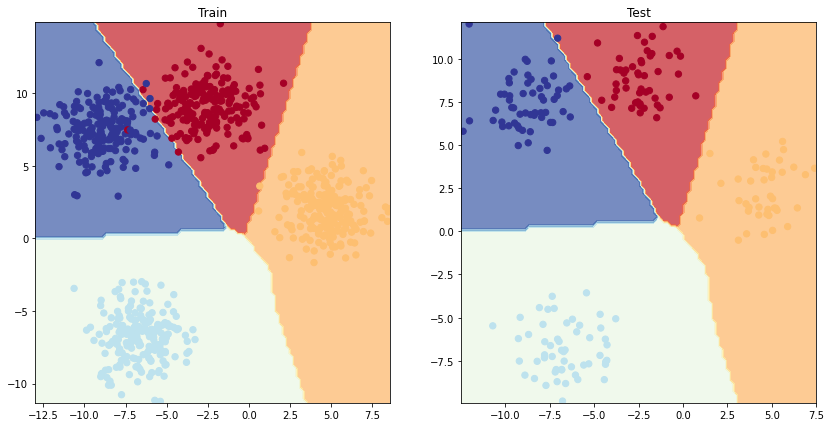

In [126]:
# Plot decision boundaries
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_4, X_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [128]:
# Model classification metrics
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 26.3 MB/s eta 0:00:00


In [131]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task='multiclass', num_classes=4)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950)